In [37]:
import numpy as np   
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from networkx.generators.atlas import *
from networkx.algorithms.isomorphism.isomorph import graph_could_be_isomorphic as isomorphic
import random
from sklearn.model_selection import GridSearchCV

#EPIDEMIC ON NETWORKS 
#https://epidemicsonnetworks.readthedocs.io/en/latest/GettingStarted.html
#FROM the book 
#Mathematics of Epidemics on Networks: from Exact to Approximate Models
#István Z. KissJoel C. MillerPéter L. Simon
#Springer Link

#Install EON
#!pip install EoN
import EoN

In [2]:
def SIR_net(G, beta, mu, initial_infecteds):



    #INITIALISATION
    inf_status={}  #infectious status of a node: 0= susceptible; 1= infectious; 2= recovered 
    for i in range(G.number_of_nodes()):
        inf_status[i]= 0
    for i in initial_infecteds:
        inf_status[i]=1  
    nx.set_node_attributes(G,inf_status, 'inf_status')
    nx.set_node_attributes(G,inf_status, 'new_inf_status')

    #SIMULATION
    #one single iteration
    time=[]
    S=[]
    I=[]
    R=[]
    time.append(0)
    S.append(N-len(initial_infecteds))
    I.append(len(initial_infecteds))
    R.append(0)
    t=0
    while True:
        
        t+=1
        time.append(t)

        #transmission and recovery
        for i in nx.nodes(G):
            if G.nodes[i]['inf_status']==1:
                if random.uniform(0,1)<mu:
                    G.nodes[i]['new_inf_status']=2
            elif G.nodes[i]['inf_status']==0:
                for j in nx.all_neighbors(G, i):
                    if G.nodes[j]['inf_status']==1:
                        if random.uniform(0,1)<beta:
                            G.nodes[i]['new_inf_status']=1
                            break
    
    

        #update infectious status                    
        for i in nx.nodes(G):
            G.nodes[i]['inf_status']=G.nodes[i]['new_inf_status']

        #compute total number of susceptible, infectious, recovered
        suscep=0
        infect=0
        recov=0
        for i in nx.nodes(G):
            if G.nodes[i]['inf_status']==0:
                suscep+=1
            elif G.nodes[i]['inf_status']==1:
                infect+= 1
            elif G.nodes[i]['inf_status']==2:
                recov+= 1
        S.append(suscep)
        I.append(infect)
        R.append(recov)

        #end simulation if no mode infectious    
        if infect==0:
            break

    return np.array(time), np.array(S), np.array(I), np.array(R)


In [138]:
def SIR_net_adaptive(G, NET, beta, mu, r, h,pro ,initial_infecteds, initial_no_vax):



    #INITIALISATION
    inf_status={}  #infectious status of a node: 0= susceptible; 1= infectious; 2= recovered 
    for i in range(G.number_of_nodes()):
        inf_status[i]= 0
    for i in initial_infecteds:
        inf_status[i]=1
    nx.set_node_attributes(G,inf_status, 'inf_status')
    nx.set_node_attributes(G,inf_status, 'new_inf_status')
    
    aware_status={}
    for i in range(NET.number_of_nodes()):
        aware_status[i]=0
    for i in initial_no_vax:
        aware_status[i]=1 
    nx.set_node_attributes(NET,aware_status, 'aware_status')
    nx.set_node_attributes(NET,aware_status, 'new_aware_status')
    
    
    #SIMULATION
    #one single iteration
    time=[]
    S=[]
    I=[]
    R=[]
    Ne=[]
    NV=[]
    PV=[]
    
    time.append(0)
    
    #SIR
    S.append(N-len(initial_infecteds))
    I.append(len(initial_infecteds))
    R.append(0)
    
    #Information
    NV.append(len(initial_no_vax))
    Ne.append(N-len(initial_no_vax))
    PV.append(0)
    
    t=0
    while True:
        
        t+=1
        time.append(t)
        
        #transmission and recovery
        for i in nx.nodes(G):
            
            # all possible transitions
            if (NET.nodes[i]['aware_status']==2) and (G.nodes[i]['inf_status']==0):         # provax that get vaccine
                rand = random.uniform(0,1)
                if rand<r:
                    G.nodes[i]['new_inf_status']=2
                    
                    
            if G.nodes[i]['inf_status']==1:                                             # infectuous that become recovered
                if random.uniform(0,1)<mu:
                    G.nodes[i]['new_inf_status']=2
                    
            elif G.nodes[i]['inf_status']==0:                                              # susceptible 
                
                if (NET.nodes[i]['aware_status']==2) or (NET.nodes[i]['aware_status']==0): #that can be
                    gamma = 1                                                              #normal persons
                else: 
                    gamma = h                                                              # or no vax
                for j in nx.all_neighbors(G, i):
                    if G.nodes[j]['inf_status']==1:
                        if random.uniform(0,1)<beta/gamma:                                 # here they get the disease
                            G.nodes[i]['new_inf_status']=1
                            
                            
            if NET.nodes[i]['aware_status']==0:                                          # a neutral person can:
                if random.uniform(0,1)<pro:
                    NET.nodes[i]['new_aware_status']=2                                   # becomes a pro vax from TV
                    continue
                
                for j in nx.all_neighbors(NET, i):                                         # or looking around
                    x = 0
                    y = 0
                    non = 0
                    if NET.nodes[j]['aware_status']==1:
                        x = x+1
                    if NET.nodes[j]['aware_status']==2:
                        y = y+1
                    non = len(list(nx.all_neighbors(NET, i)))-x-y
                        
                random2 = random.uniform(0,1)
                random3 = random.uniform(0,1)
                    
                if random2 < random3 and random2 < x/(non+x+y):
                    NET.nodes[i]['new_aware_status']=1                                    # becomes a novax via neighbours
                                    
                elif random3 < random2 and random3 < y/(non+x+y):                           # becomes a provax via neighbours
                    NET.nodes[i]['new_aware_status']=2
                            
        # the lists of nodes which are useful for rewiring
        neutral = []
        novax   = []
        provax  = []
        
        for u in nx.nodes(NET):
            if NET.nodes[u]['aware_status']==0  :
                neutral.append(u)
            elif NET.nodes[u]['aware_status']==1  :
                novax.append(u)
            else: provax.append(u)  

        # rewiring
        v = nx.edges(NET)  
        for i in v:      
            i = list(i)  
            if (NET.nodes[i[0]]['aware_status'] + NET.nodes[i[1]]['aware_status'] ==3): 
                if random.uniform(0,1)<0.5:    
                    NET.remove_edge(i[0],i[1])   
                    if random.uniform(0,1)<0.3:   
                        if NET.nodes[i[0]]['aware_status']==2:
                            NET.add_edge(i[1],np.random.choice(novax)) 
                            NET.add_edge(i[0],np.random.choice(provax))
                        else:
                            NET.add_edge(i[0],np.random.choice(novax)) 
                            NET.add_edge(i[1],np.random.choice(provax))

        
        #update infectious status                    
        for i in nx.nodes(G):
            G.nodes[i]['inf_status']=G.nodes[i]['new_inf_status']
        for i in nx.nodes(NET):
            NET.nodes[i]['aware_status']=NET.nodes[i]['new_aware_status']


        #compute total number of susceptible, infectious, recovered
        suscep=0
        infect=0
        recov=0
        for i in nx.nodes(G):
            if G.nodes[i]['inf_status']==0:
                suscep+=1
            elif G.nodes[i]['inf_status']==1:
                infect+= 1
        recov = len(nx.nodes(G)) - suscep - infect
        S.append(suscep)
        I.append(infect)
        R.append(recov)

        #end simulation if no mode infectious    
        if infect==0:
            break

    return np.array(time), np.array(S), np.array(I), np.array(R)

19926

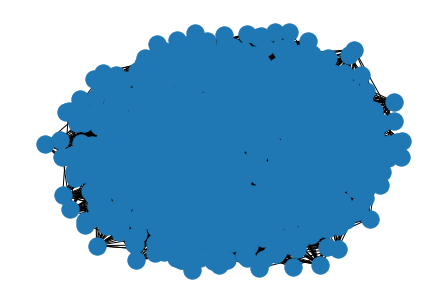

In [139]:
N= 1000 #number of nodes 
p= 0.004  #edge probability
ERG= nx.erdos_renyi_graph(N, p)
ERG2 = nx.erdos_renyi_graph(N, 10*p)
nx.draw(ERG2)
len(nx.edges(ERG2))

Text(0.5, 0, 'time')

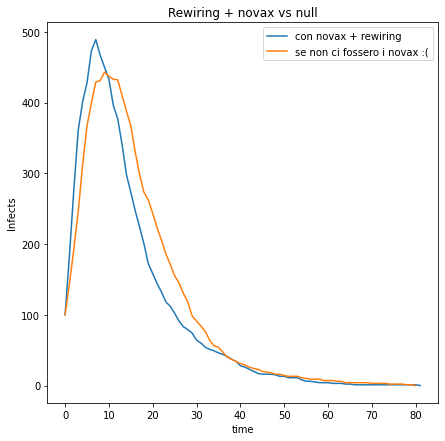

In [141]:
b = SIR_net(ERG, 0.15, 0.1, initial_infecteds=np.arange(100))
a = SIR_net_adaptive(ERG,ERG2, beta=0.15, mu=0.1, r=0.1, h=0.1, pro=0.1, initial_infecteds=np.arange(100), initial_no_vax = np.arange(200,400))

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.plot(a[0],a[2], label= "con novax + rewiring")
ax.plot(b[0],b[2], label= "se non ci fossero i novax :(")
ax.legend()
ax.set_title("Rewiring + novax vs null")
ax.set_ylabel("Infects")
ax.set_xlabel("time")

### No Vax?

13575

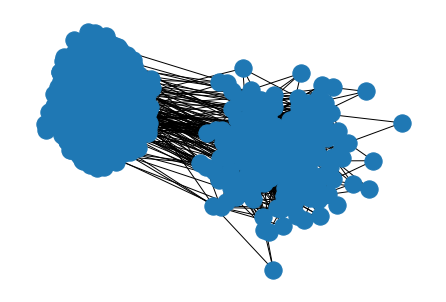

In [45]:
#dopo 20 iterazioni 
nx.draw(ERG2)
len(nx.edges(ERG2))

10414

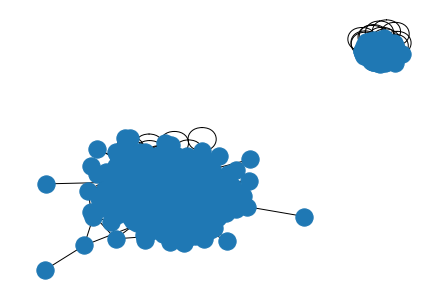

In [33]:
# a fine epidemia

nx.draw(ERG2)
len(nx.edges(ERG2))

### Tentativo di Gridsearch

In [133]:
def SIR_net_adaptive2(G, NET, beta, mu, pro ,initial_infecteds, initial_no_vax, r=1, h=1):



    #INITIALISATION
    inf_status={}  #infectious status of a node: 0= susceptible; 1= infectious; 2= recovered 
    for i in range(G.number_of_nodes()):
        inf_status[i]= 0
    for i in initial_infecteds:
        inf_status[i]=1
    nx.set_node_attributes(G,inf_status, 'inf_status')
    nx.set_node_attributes(G,inf_status, 'new_inf_status')
    
    aware_status={}
    for i in range(NET.number_of_nodes()):
        aware_status[i]=0
    for i in initial_no_vax:
        aware_status[i]=1 
    nx.set_node_attributes(NET,aware_status, 'aware_status')
    nx.set_node_attributes(NET,aware_status, 'new_aware_status')
    
    
    #SIMULATION
    #one single iteration
    time=[]
    S=[]
    I=[]
    R=[]
    Ne=[]
    NV=[]
    PV=[]
    
    time.append(0)
    
    #SIR
    S.append(N-len(initial_infecteds))
    I.append(len(initial_infecteds))
    R.append(0)
    
    #Information
    NV.append(len(initial_no_vax))
    Ne.append(N-len(initial_no_vax))
    PV.append(0)
    
    t=0
    while True:
        
        t+=1
        time.append(t)
        
        #transmission and recovery
        for i in nx.nodes(G):
            
            # all possible transitions
            if (NET.nodes[i]['aware_status']==2) and (G.nodes[i]['inf_status']==0):         # provax that get vaccine
                rand = random.uniform(0,1)
                if rand<r:
                    G.nodes[i]['new_inf_status']=2
                    
                    
            if G.nodes[i]['inf_status']==1:                                             # infectuous that become recovered
                if random.uniform(0,1)<mu:
                    G.nodes[i]['new_inf_status']=2
                    
            elif G.nodes[i]['inf_status']==0:                                              # susceptible 
                
                if (NET.nodes[i]['aware_status']==2) or (NET.nodes[i]['aware_status']==0): #that can be
                    gamma = 1                                                              #normal persons
                else: 
                    gamma = h                                                              # or no vax
                for j in nx.all_neighbors(G, i):
                    if G.nodes[j]['inf_status']==1:
                        if random.uniform(0,1)<beta/gamma:                                 # here they get the disease
                            G.nodes[i]['new_inf_status']=1
                            
                            
            if NET.nodes[i]['aware_status']==0:                                          # a neutral person can:
                if random.uniform(0,1)<pro:
                    NET.nodes[i]['new_aware_status']=2                                   # becomes a pro vax from TV
                    continue
                
                for j in nx.all_neighbors(NET, i):                                         # or looking around
                    x = 0
                    y = 0
                    non = 0
                    if NET.nodes[j]['aware_status']==1:
                        x = x+1
                    if NET.nodes[j]['aware_status']==2:
                        y = y+1
                    non = len(list(nx.all_neighbors(NET, i)))-x-y
                        
                random2 = random.uniform(0,1)
                random3 = random.uniform(0,1)
                    
                if random2 < random3 and random2 < x/(non+x+y):
                    NET.nodes[i]['new_aware_status']=1                                    # becomes a novax via neighbours
                                    
                elif random3 < random2 and random3 < y/(non+x+y):                           # becomes a provax via neighbours
                    NET.nodes[i]['new_aware_status']=2
                            
        # the lists of nodes which are useful for rewiring
        neutral = []
        novax   = []
        provax  = []
        
        for u in nx.nodes(NET):
            if NET.nodes[u]['aware_status']==0  :
                neutral.append(u)
            elif NET.nodes[u]['aware_status']==1  :
                novax.append(u)
            else: provax.append(u)  

        # rewiring
        v = nx.edges(NET)  
        for i in v:      
            i = list(i)  
            if (NET.nodes[i[0]]['aware_status'] + NET.nodes[i[1]]['aware_status'] ==3): 
                if random.uniform(0,1)<0.5:    
                    NET.remove_edge(i[0],i[1])   
                    if random.uniform(0,1)<0.3:   
                        if NET.nodes[i[0]]['aware_status']==2:
                            NET.add_edge(i[1],np.random.choice(novax)) 
                            NET.add_edge(i[0],np.random.choice(provax))
                        else:
                            NET.add_edge(i[0],np.random.choice(novax)) 
                            NET.add_edge(i[1],np.random.choice(provax))

        
        #update infectious status                    
        for i in nx.nodes(G):
            G.nodes[i]['inf_status']=G.nodes[i]['new_inf_status']
        for i in nx.nodes(NET):
            NET.nodes[i]['aware_status']=NET.nodes[i]['new_aware_status']


        #compute total number of susceptible, infectious, recovered
        suscep=0
        infect=0
        
        for i in nx.nodes(G):
            if G.nodes[i]['inf_status']==0:
                suscep+=1
            elif G.nodes[i]['inf_status']==1:
                infect+= 1
        recover = len(nx.nodes(G)) - suscep - infect
        S.append(suscep)
        I.append(infect)
        R.append(recov)

        #end simulation if no mode infectious    
        if infect==0:
            break

    return [np.max(np.array(I)/len(nx.nodes(G))), np.max(np.array(R)/len(nx.nodes(G)))]

In [105]:
# 600 sec circa

r=np.arange(1,10)/10
h=np.arange(1,10)/10

out1 = np.zeros((len(r),len(h)))

out2 = np.zeros((len(r),len(h)))
               
for i in range(len(r)):
    for j in range(len(h)):
        
        out1[i][j] = SIR_net_adaptive2(G = ERG, NET = ERG2, beta = 0.15, mu = 0.1, pro = 0.1,
                                      initial_infecteds=np.arange(100), initial_no_vax = np.arange(200,400),
                                      r = r[i], h = h[j])[0]
        
        
        out2[i][j] = SIR_net_adaptive2(G = ERG, NET = ERG2, beta = 0.15, mu = 0.1, pro = 0.1,
                                      initial_infecteds=np.arange(100), initial_no_vax = np.arange(200,400),
                                      r = r[i], h = h[j])[1]

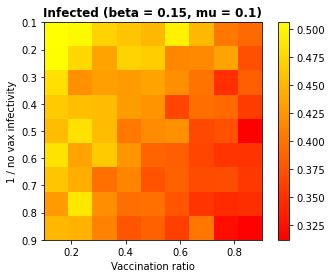

In [146]:
a = plt.imshow( out1 , cmap = 'autumn' , interpolation = 'nearest', extent = [min(r), max(r),max(h), min(h)] )
plt.colorbar(a)
plt.title('Infected (beta = 0.15, mu = 0.1)', fontweight ="bold")
plt.xlabel("Vaccination ratio")
plt.ylabel("1 / no vax infectivity")
plt.show()

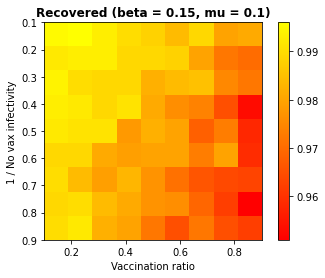

In [147]:
b = plt.imshow( out2 , cmap = 'autumn' , interpolation = 'nearest', extent = [min(r), max(r),max(h), min(h)] )
plt.colorbar(b)
plt.title('Recovered (beta = 0.15, mu = 0.1)', fontweight ="bold")
plt.xlabel("Vaccination ratio")
plt.ylabel("1 / No vax infectivity")
plt.show()